## Redes Neurais Artificiais 2025.1

- **Disciplina**: Redes Neurais Artificiais 2025.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  
- **Github**: http://github.com/elloa  

|Alunos                |Matrícula  |
|----------------------|-----------|
|Caio Bertoldo         |2215080050 |
|Danilo Jorge          |2215080007 |
|Diogo Gomes           |2215080033 |
|Guilherme Montenegro  |2215080011 |
|Leonardo Abinader     |2215080042 |
|Rodolfo Simões        |2215080073 |

### Tarefa de aprendizado - SVM

In [46]:
# Importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
import joblib
import os


In [47]:
# Criar pasta 'svm' para armazenar os modelos treinados:
os.makedirs('svm', exist_ok = True)

In [48]:
# Importando o Dataset ajustado para treino:
df = pd.read_csv("datasets/updated_pollution_dataset_encoded.csv")
df.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality Encoded
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,2
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,2
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,2
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,0
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,0


In [49]:
# Separação dos conjuntos
X = df.drop('Air Quality Encoded', axis = 1)
y = df['Air Quality Encoded']

In [50]:
# Separando em dados de treino e teste (80% = treino / 20% = teste)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 34)

=== Resultados de Avaliação ===
Acurácia:  74.90%
Precisão:  74.64%
Recall:    64.41%
F1-Score:  66.44%


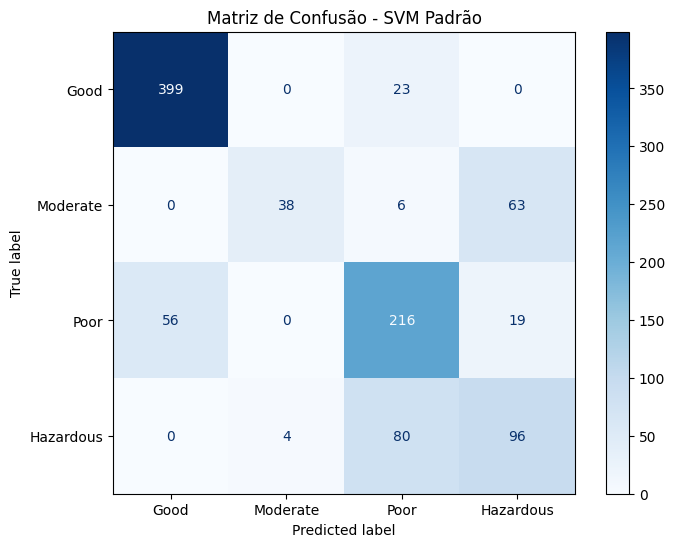

In [51]:
# Testando modelo default SVM

svm_model = SVC()
svm_model.fit(X_train, y_train)
target_classes = ["Good", "Moderate", "Poor", "Hazardous"]


y_pred = svm_model.predict(X_test)

# Métricas de avaliação
accuracy_p = accuracy_score(y_test, y_pred)
precision_p = precision_score(y_test, y_pred, average = 'macro')
recall_p = recall_score(y_test, y_pred, average = 'macro')
f1_p = f1_score(y_test, y_pred, average = 'macro')

print("=== Resultados de Avaliação ===")
print(f"Acurácia:  {accuracy_p * 100:.2f}%")
print(f"Precisão:  {precision_p * 100:.2f}%")
print(f"Recall:    {recall_p * 100:.2f}%")
print(f"F1-Score:  {f1_p * 100:.2f}%")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_classes)
fig, ax = plt.subplots(figsize = (8, 6))
disp.plot(ax=  ax, cmap = 'Blues', colorbar = True)

plt.title('Matriz de Confusão - SVM Padrão')
plt.show()

In [52]:
# Salvando o arquivo do modelo de SVM padrão:
joblib.dump(svm_model, 'svm/svm_air_quality_standard.joblib')

['svm/svm_air_quality_standard.joblib']

### SVM com GridSearch

O GridSearchCV é uma técnica de busca sistemática que testa várias combinações possíveis de parâmetros (pré-definidos) fornecidos para um modelo e avalia cada combinação usando validação cruzada (cross-validation). 

Essa abordagem é útil porque evita escolhas arbitrárias de parâmetros e ajuda a encontrar automaticamente a configuração que maximiza o desempenho do modelo (como acurácia ou F1-score) no conjunto de validação. 

In [53]:
# Utilizando o GridSearchCV para encontrar os melhores parâmetros:

param_grid = {
    'C': [0.1, 1, 10, 100],           # Penalidade de margem
    'gamma': ['scale', 0.01, 0.1, 1], # Coeficiente do kernel RBF e sigmoid
    'kernel': ['rbf', 'linear', 'sigmoid']       # Tipos de kernel
}

grid_search = GridSearchCV(estimator = SVC(),
                           param_grid = param_grid,
                           cv = 5,  # 5-fold cross-validation
                           n_jobs = -1,  # usa todos os núcleos da cpu
                           scoring = 'f1_macro',  # para multiclasse
                           verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 0.01, 0.1, 1],
                         'kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='f1_macro', verbose=2)

In [54]:
print("\nMelhores parâmetros encontrados:", grid_search.best_params_)
print(f"Melhor F1-score médio: {grid_search.best_score_ * 100:.2f}%")


Melhores parâmetros encontrados: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Melhor F1-score médio: 91.38%


In [55]:
# Treinando o modelo com os melhores parâmetros encontrados pelo GridSearchCV:

final_model = SVC(**grid_search.best_params_, random_state = 34)
final_model.fit(X_train, y_train)

# Avaliar no conjunto de teste real
y_final_pred = final_model.predict(X_test)

# Métricas de avaliação
accuracy_g = accuracy_score(y_test, y_final_pred)
precision_g = precision_score(y_test, y_final_pred, average = 'macro')  # macro para multiclasse
recall_g = recall_score(y_test, y_final_pred, average = 'macro')
f1_g = f1_score(y_test, y_final_pred, average = 'macro')

print("=== Resultados de Avaliação ===")
print(f"Acurácia:  {accuracy_g * 100:.2f}%")
print(f"Precisão:  {precision_g * 100:.2f}%")
print(f"Recall:    {recall_g * 100:.2f}%")
print(f"F1-Score:  {f1_g * 100:.2f}%")


=== Resultados de Avaliação ===
Acurácia:  94.00%
Precisão:  91.88%
Recall:    89.90%
F1-Score:  90.76%


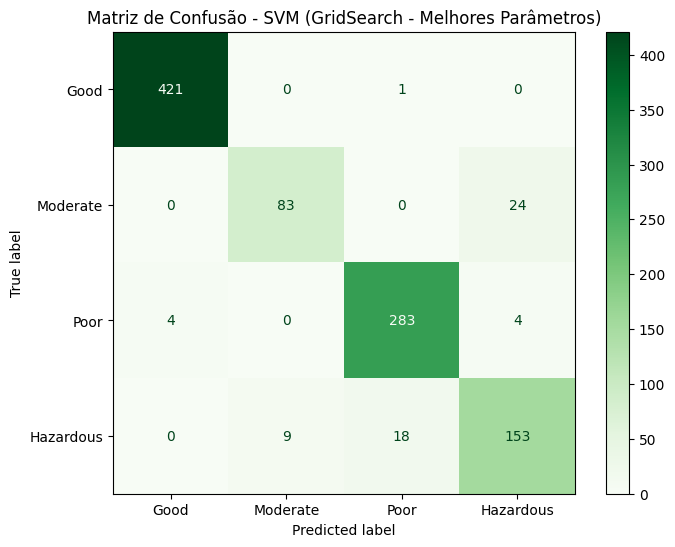

In [56]:
cm = confusion_matrix(y_test, y_final_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_classes)
fig, ax = plt.subplots(figsize = (8, 6))

disp.plot(ax = ax, cmap = 'Greens', colorbar = True)
plt.title('Matriz de Confusão - SVM (GridSearch - Melhores Parâmetros)')

plt.show()

In [57]:
# Salvando o arquivo do modelo de SVM com os melhores resultados do GridSearchCV:

joblib.dump(final_model, 'svm/svm_air_quality_gridsearch.joblib')

['svm/svm_air_quality_gridsearch.joblib']

### SVM com BayesSearchCV

A BayesSearchCV é uma técnica de otimização bayesiana usada para ajustar hiperparâmetros de modelos de machine learning. Ela começa testando algumas combinações de forma aleatória, cria um modelo probabilístico, e vai atualizando o modelo a cada iteração, escolhendo a próxima combinação com expectativa de melhora, repetindo esse processo por n_iter vezes.

In [36]:
#Definir espaço de busca para os hiperparâmetros
search_space = {
    'C': Real(0.1, 100.0, prior='log-uniform'),
    'gamma': Real(0.0001, 1.0, prior='log-uniform'), 
    'kernel': Categorical(['rbf', 'linear', 'sigmoid'])
}

In [ ]:
# Criar o BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=SVC(),
    search_spaces=search_space,
    n_iter=50,     
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

# Treinar e buscar melhores hiperparâmetros
bayes_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:", bayes_search.best_params_)
print(f"Melhor F1-score médio (cross-validation): {bayes_search.best_score_ * 100:.2f}%")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [100.0, 1.0, 'linear'] before, using random point [0.205968562252686, 0.00014110558478404873, 'sigmoid']
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [41]:
best_bayes_model = bayes_search.best_estimator_
y_bayes_pred = best_bayes_model.predict(X_test)

# Métricas de avaliação no conjunto de teste
accuracy_b = accuracy_score(y_test, y_bayes_pred)
precision_b = precision_score(y_test, y_bayes_pred, average = 'macro')
recall_b = recall_score(y_test, y_bayes_pred, average = 'macro')
f1_b = f1_score(y_test, y_bayes_pred, average = 'macro')

print("\n=== Resultados no conjunto de teste ===")
print(f"Acurácia:  {accuracy_b * 100:.2f}%")
print(f"Precisão:  {precision_b * 100:.2f}%")
print(f"Recall:    {recall_b * 100:.2f}%")
print(f"F1-Score:  {f1_b * 100:.2f}%")


=== Resultados no conjunto de teste ===
Acurácia:  94.10%
Precisão:  91.78%
Recall:    89.98%
F1-Score:  90.77%


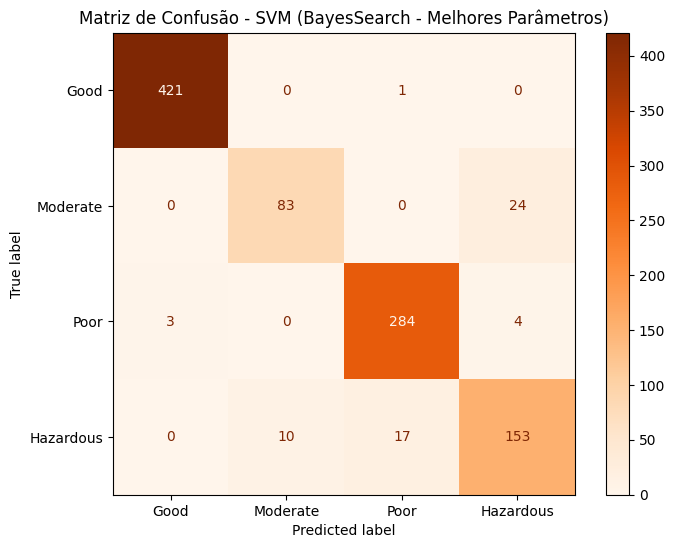

In [42]:
cm = confusion_matrix(y_test, y_bayes_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_classes)
fig, ax = plt.subplots(figsize = (8, 6))

disp.plot(ax = ax, cmap = 'Oranges', colorbar = True)
plt.title('Matriz de Confusão - SVM (BayesSearch - Melhores Parâmetros)')

plt.show()

In [ ]:
# Salvando o arquivo do modelo de SVM com os melhores resultados do BayesSearchCV:
joblib.dump(best_bayes_model, 'svm/svm_air_quality_bayessearch.joblib')

['svm/svm_air_quality_bayessearch.joblib']

### Conclusões:
A comparação entre as abordagens mostra que a GridSearchCV e a BayesSearchCV obtiveram resultados muito parecidos, enquanto a opção de SVM default obteve um resultado pouco satisfatório.

In [59]:
data = {
    'Modelo': ['SVM Padrão', 'GridSearchCV', 'BayesSearchCV'],
    'Acurácia': [accuracy_p, accuracy_g, accuracy_b],
    'Precisão': [precision_p, precision_g, precision_b],
    'Recall': [recall_p, recall_g, recall_b],
    'F1-Score': [f1_p, f1_g, f1_b]
}

# Criar DataFrame
df_resultados = pd.DataFrame(data)

# Converter para porcentagem com duas casas decimais
colunas_metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
df_resultados[colunas_metricas] = df_resultados[colunas_metricas].map(lambda x: f"{x * 100:.2f}%")

# Exibir tabela
print("\n=== Comparação de Modelos ===\n")
print(df_resultados.to_string(index = False))


=== Comparação de Modelos ===

       Modelo Acurácia Precisão Recall F1-Score
   SVM Padrão   74.90%   74.64% 64.41%   66.44%
 GridSearchCV   94.00%   91.88% 89.90%   90.76%
BayesSearchCV   94.10%   91.78% 89.98%   90.77%
